In [1]:
import numpy as np
import pandas as pd
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tools.eval_measures import rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load datasets
df = pd.read_csv(r'F:\DS\Time_Series_Analysis\[ FreeCourseWeb.com ] Udemy - Python for Time Series Data Analysis\01. Introduction\UDEMY_TSA_FINAL\Data\M2SLMoneyStock.csv',index_col=0, parse_dates=True)
df.index.freq = 'MS'

sp = pd.read_csv(r'F:\DS\Time_Series_Analysis\[ FreeCourseWeb.com ] Udemy - Python for Time Series Data Analysis\01. Introduction\UDEMY_TSA_FINAL\Data\PCEPersonalSpending.csv',index_col=0, parse_dates=True)
sp.index.freq = 'MS'

### inspect_the_Data

In [2]:
df = df.join(sp)
df.head()

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1


### Plot_the_Source

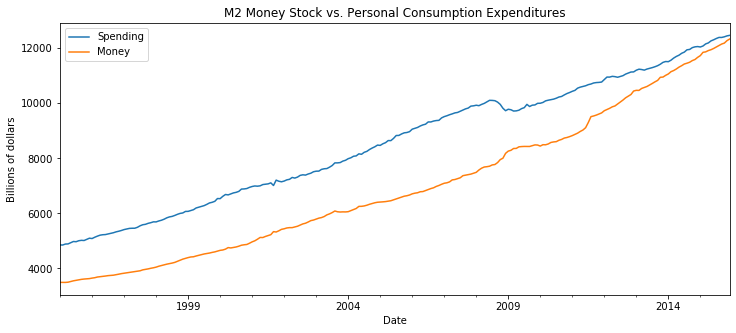

In [3]:
title = 'M2 Money Stock vs. Personal Consumption Expenditures'
ylabel='Billions of dollars'
xlabel=''

ax = df['Spending'].plot(figsize=(12,5),title=title,legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
df['Money'].plot(legend=True);

## Test_for_Stationarity_and_Do_Required_Trasformation

In [4]:
# INCLUDED HERE IF YOU CHOOSE TO USE IT
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [5]:
auto_arima(df['Money'],maxiter=1000)

ARIMA(maxiter=1000, method='lbfgs', order=(3, 2, 3), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 1),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)

In [6]:
auto_arima(df['Spending'],maxiter=1000)

ARIMA(maxiter=1000, method='lbfgs', order=(1, 1, 2), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 1),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)

It looks like a VARMA(1,2) model is recommended. Note that the 𝑑 term (2 for Money, 1 for Spending [Middle_Values_of_(I)] is about to be addressed by transforming the data to make it stationary. As before we'll apply a second order difference.

In [7]:
df_transformed = df.diff().diff()
df_transformed = df_transformed.dropna()
df_transformed.head()

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7


In [8]:
len(df_transformed)

250

### Train_Test_Split

In [9]:
nobs=12
train, test = df_transformed[0:-nobs], df_transformed[-nobs:]

In [10]:
print(train.shape)
print(test.shape)

(238, 2)
(12, 2)


## Fit the VARMA(1,2) Model

In [11]:
model = VARMAX(train, order=(1,2), trend='c')
results = model.fit(maxiter=1000, disp=False)
results.summary()

Dep. Variable:,"['Money', 'Spending']",No. Observations:,238
Model:,"VARMA(1,2)",Log Likelihood,-2286.664
,+ intercept,AIC,4607.328
Date:,"Sun, 02 Feb 2020",BIC,4666.356
Time:,14:55:14,HQIC,4631.117
Sample:,03-01-1995,,
,- 12-01-2014,,
Covariance Type:,opg,,
Ljung-Box (Q):,"68.64, 28.60",Jarque-Bera (JB):,"534.46, 119.49"
Prob(Q):,"0.00, 0.91",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"5.64, 2.87",Skew:,"1.31, -0.32"


### Predict the next 12 values

In [12]:
df_forecast = results.forecast(12)
df_forecast

,Money,Spending
2015-01-01,-11.108957,35.985539
2015-02-01,-11.406528,-4.132794
2015-03-01,1.597045,-0.382002
2015-04-01,-1.703191,-0.276573
2015-05-01,1.130332,0.099211
2015-06-01,-0.422255,-0.045906
2015-07-01,0.543208,0.056751
2015-08-01,-0.033718,-0.002359
2015-09-01,0.315251,0.033814
2015-10-01,0.104958,0.012093


### Invert_The_Transform

In [13]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Money1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + df_forecast['Money'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['MoneyForecast'] = df['Money'].iloc[-nobs-1] + df_forecast['Money'].cumsum()

In [14]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Spending1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + df_forecast['Spending'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + df_forecast['Spending'].cumsum()

In [15]:
df_forecast

,Money,Spending,Money1d,MoneyForecast,Spending1d,SpendingForecast
2015-01-01,-11.108957,35.985539,67.491043,11658.991043,46.585539,12097.985539
2015-02-01,-11.406528,-4.132794,56.084515,11647.584515,42.452745,12093.852745
2015-03-01,1.597045,-0.382002,57.681560,11649.181560,42.070743,12093.470743
2015-04-01,-1.703191,-0.276573,55.978369,11647.478369,41.794170,12093.194170
2015-05-01,1.130332,0.099211,57.108700,11648.608700,41.893381,12093.293381
2015-06-01,-0.422255,-0.045906,56.686446,11648.186446,41.847474,12093.247474
2015-07-01,0.543208,0.056751,57.229654,11648.729654,41.904225,12093.304225
2015-08-01,-0.033718,-0.002359,57.195936,11648.695936,41.901866,12093.301866
2015-09-01,0.315251,0.033814,57.511188,11649.011188,41.935680,12093.335680
2015-10-01,0.104958,0.012093,57.616146,11649.116146,41.947773,12093.347773


In [16]:
pd.concat([df.iloc[-12:],df_forecast[['MoneyForecast','SpendingForecast']]],axis=1)

,Money,Spending,MoneyForecast,SpendingForecast
Date,,,,
2015-01-01,11733.2,12046.0,11658.991043,12097.985539
2015-02-01,11852.4,12082.4,11647.584515,12093.852745
2015-03-01,11868.8,12158.3,11649.181560,12093.470743
2015-04-01,11916.1,12193.8,11647.478369,12093.194170
2015-05-01,11947.6,12268.1,11648.608700,12093.293381
2015-06-01,11993.1,12308.3,11648.186446,12093.247474
2015-07-01,12045.3,12355.4,11648.729654,12093.304225
2015-08-01,12096.8,12394.0,11648.695936,12093.301866
2015-09-01,12153.8,12392.8,11649.011188,12093.335680


## Plot_The_Results

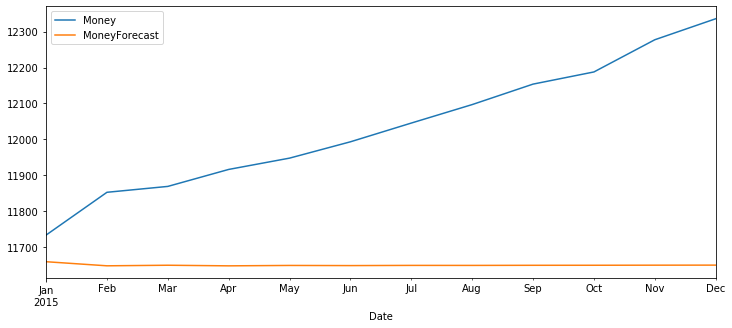

In [17]:
df['Money'][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['MoneyForecast'].plot(legend=True);

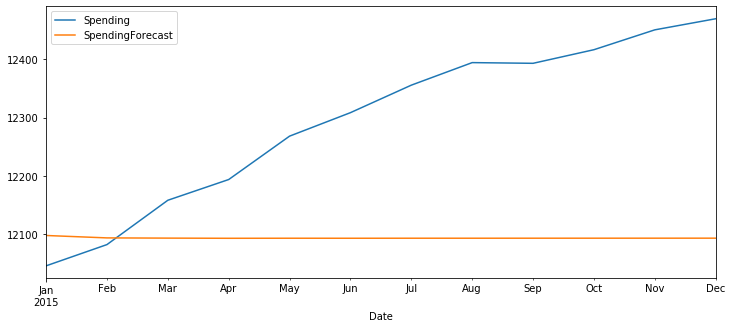

In [18]:
df['Spending'][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['SpendingForecast'].plot(legend=True);

## Evaluate_The_Model

In [19]:
RMSE1 = rmse(df['Money'][-nobs:], df_forecast['MoneyForecast'])
print(f'Money VAR(5) RMSE: {RMSE1:.3f}')

Money VAR(5) RMSE: 422.763


In [20]:
RMSE2 = rmse(df['Spending'][-nobs:], df_forecast['SpendingForecast'])
print(f'Spending VAR(5) RMSE: {RMSE2:.3f}')

Spending VAR(5) RMSE: 244.154


### Let's compare these results to individual ARMA(1,2) models

In [21]:
from statsmodels.tsa.arima_model import ARMA,ARMAResults

## Money

In [22]:
model = ARMA(train['Money'],order=(1,2))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Money   No. Observations:                  238
Model:                     ARMA(1, 2)   Log Likelihood               -1117.710
Method:                       css-mle   S.D. of innovations             26.215
Date:                Sun, 02 Feb 2020   AIC                           2245.421
Time:                        14:58:29   BIC                           2262.782
Sample:                    03-01-1995   HQIC                          2252.418
                         - 12-01-2014                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1814      0.029      6.302      0.000       0.125       0.238
ar.L1.Money    -0.3568      0.293     -1.217      0.225      -0.931       0.218
ma.L1.Money    -0.4087      0.260     -1.572      0.117      -0.918       0.101
ma.L2.Money    -0.5912      0.260     -2.278      0.024      -1.100      -0.082
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.8023           +0.0000j            2.8023            0.5000
MA.1            1.0001           +0.0000j            1.0001            0.0000
MA.2           -1.6914           +0.0000j            1.6914            0.5000
-----------------------------------------------------------------------------
"""

In [23]:
start=len(train)
end=len(train)+len(test)-1
z1 = results.predict(start=start, end=end).rename('Money')
z1 = pd.DataFrame(z1)

In [24]:
z1

,Money
2015-01-01,-14.498799
2015-02-01,-10.946846
2015-03-01,4.152460
2015-04-01,-1.235660
2015-05-01,0.687067
2015-06-01,0.000950
2015-07-01,0.245788
2015-08-01,0.158419
2015-09-01,0.189596
2015-10-01,0.178471


### Invert_The_Trasform_and_Evaluate_The_Models

In [25]:
# Add the most recent first difference from the training set to the forecast cumulative sum
z1['Money1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + z1['Money'].cumsum()

# Now build the forecast values from the first difference set
z1['MoneyForecast'] = df['Money'].iloc[-nobs-1] + z1['Money1d'].cumsum()

In [26]:
z1

,Money,Money1d,MoneyForecast
2015-01-01,-14.498799,64.101201,11734.201201
2015-02-01,-10.946846,53.154354,11787.355555
2015-03-01,4.152460,57.306814,11844.662369
2015-04-01,-1.235660,56.071155,11900.733524
2015-05-01,0.687067,56.758221,11957.491745
2015-06-01,0.000950,56.759172,12014.250916
2015-07-01,0.245788,57.004959,12071.255876
2015-08-01,0.158419,57.163378,12128.419254
2015-09-01,0.189596,57.352974,12185.772228
2015-10-01,0.178471,57.531445,12243.303673


In [27]:
RMSE3 = rmse(df['Money'][-nobs:], z1['MoneyForecast'])

print(f'Money VARMA(1,2) RMSE: {RMSE1:.3f}')
print(f'Money  ARMA(1,2) RMSE: {RMSE3:.3f}')

Money VARMA(1,2) RMSE: 422.763
Money  ARMA(1,2) RMSE: 32.237


## Personal_Spending

In [28]:
model = ARMA(train['Spending'],order=(1,2))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               Spending   No. Observations:                  238
Model:                     ARMA(1, 2)   Log Likelihood               -1182.411
Method:                       css-mle   S.D. of innovations             34.661
Date:                Sun, 02 Feb 2020   AIC                           2374.823
Time:                        15:00:10   BIC                           2392.184
Sample:                    03-01-1995   HQIC                          2381.820
                         - 12-01-2014                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0856      0.245      0.350      0.727      -0.394       0.565
ar.L1.Spending    -0.3403      0.511     -0.666      0.506      -1.342       0.661
ma.L1.Spending    -0.6451      0.521     -1.237      0.217      -1.667       0.377
ma.L2.Spending    -0.2139      0.485     -0.441      0.660      -1.165       0.737
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.9387           +0.0000j            2.9387            0.5000
MA.1            1.1281           +0.0000j            1.1281            0.0000
MA.2           -4.1437           +0.0000j            4.1437            0.5000
-----------------------------------------------------------------------------
"""

In [29]:
start=len(train)
end=len(train)+len(test)-1
z2 = results.predict(start=start, end=end).rename('Spending')
z2 = pd.DataFrame(z2)
z2

,Spending
2015-01-01,33.555800
2015-02-01,-3.338235
2015-03-01,1.250716
2015-04-01,-0.310843
2015-05-01,0.220535
2015-06-01,0.039714
2015-07-01,0.101245
2015-08-01,0.080307
2015-09-01,0.087432
2015-10-01,0.085007


### Invert the Transformation, Evaluate the Forecast

In [30]:
# Add the most recent first difference from the training set to the forecast cumulative sum
z2['Spending1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + z2['Spending'].cumsum()

# Now build the forecast values from the first difference set
z2['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + z2['Spending1d'].cumsum()

In [31]:
z2

,Spending,Spending1d,SpendingForecast
2015-01-01,33.555800,44.155800,12106.155800
2015-02-01,-3.338235,40.817565,12146.973364
2015-03-01,1.250716,42.068281,12189.041645
2015-04-01,-0.310843,41.757438,12230.799083
2015-05-01,0.220535,41.977973,12272.777056
2015-06-01,0.039714,42.017687,12314.794742
2015-07-01,0.101245,42.118932,12356.913674
2015-08-01,0.080307,42.199239,12399.112913
2015-09-01,0.087432,42.286670,12441.399583
2015-10-01,0.085007,42.371678,12483.771260


In [32]:
RMSE4 = rmse(df['Spending'][-nobs:], z2['SpendingForecast'])

print(f'Spending VARMA(1,2) RMSE: {RMSE2:.3f}')
print(f'Spending  ARMA(1,2) RMSE: {RMSE4:.3f}')

Spending VARMA(1,2) RMSE: 244.154
Spending  ARMA(1,2) RMSE: 52.334
